In [1]:
%run ../modules/qpca

In [2]:
from sklearn import datasets
import numpy as np
import scipy
from math import *
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from scipy.stats import ortho_group

We load the iris dataset and compute its covariance matrix

In [6]:
dataset = datasets.load_iris()
x=dataset.data
y=dataset.target

#Center the dataset s.t. the mean is 0 for each feature
means = np.mean(x,axis=0)
u=np.ones(len(x))[None] 
u=u.reshape((len(x),1)) 
means=means.reshape((len(x[0]),1))
centered = x-np.dot(u,means.T)

#Compute the covariance matrix
covariance_matrix=(1/(len(x)-1)) * np.dot(np.transpose(np.conj(centered)), centered)
covariance_matrix = covariance_matrix/np.trace(covariance_matrix)

For reference, we compute the eigendecomposition classically. We can then identify the first 2 principal components and project the dataset onto this new feature space.

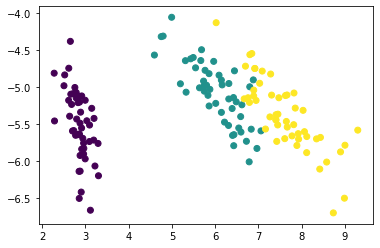

In [7]:
#compute the eigenvectors and eigenvalues
eigval, eigvec = np.linalg.eig(covariance_matrix)

#order them by eigenvalue
eva=eigval[np.argsort(eigval)[::-1]]
evs=eigvec[:,np.argsort(eigval)[::-1]]

#new feature space given by the first 2 pc
tranformation_matrix=np.array([evs[:,0],evs[:,1]])

result=np.dot(x, tranformation_matrix.T)
plt.scatter(result.T[0],result.T[1], c=y)
plt.show()

Now we will try to replicate these results using the quantum algorithm.<br>
The initial vector to be given as input to the algorithm was randomly generated.<br>
The number of qubits that determines the estimation precision of the eigenvalues is set to 4.

In [20]:
covariance_matrix = covariance_matrix/np.trace(covariance_matrix)

#random vector obtained by np.random.rand(4)*2-1
initial = [-0.90454731, -0.66289814, -0.32369894,  0.45179635]

res = qpca(covariance_matrix, 4, initial)

The histogram shows the eigenvalues found by the algorithm and how often they were measured.<br>

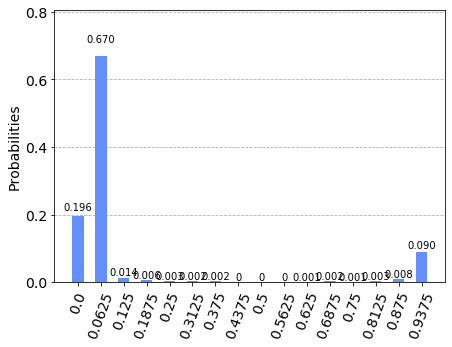

In [21]:
plot_histogram(res.get_eigvals(False))

We are interested in the eigenvectors corresponding to the largest eigenvalues. That is, $0.9375$ and $0.0625$.

In [14]:
pc1 = res.eigvec_from_eigval(0.9375)
pc2 = res.eigvec_from_eigval(0.0625)

print("PC1:",pc1)
print("PC2:",pc2)

PC1: [ 0.20244408 -0.20908335  0.90686513  0.30478874]
PC2: [ 0.66750456  0.72355771 -0.14683143 -0.09665628]


Once again, we can now plot the data in the new feature space.

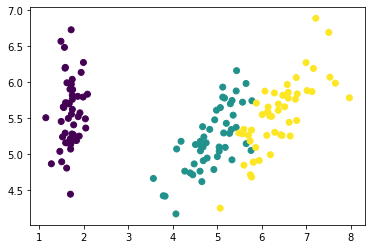

In [15]:
tranformation_matrix=np.array([pc1,pc2])
result=np.dot(x, tranformation_matrix.T)

plt.scatter(result.T[0],result.T[1], c=y)
plt.show()

From this graph we can see that the PC2 found by the quantum algorithm is the inverse of the one found by the classical algorithm.<br>
Simply inverting the $y$-axis gets us closer to our reference.

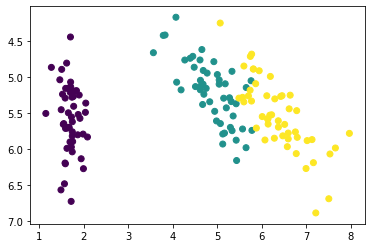

In [16]:
plt.scatter(result.T[0],result.T[1], c=y)
plt.gca().invert_yaxis()
plt.show()

Looking again at the measurements histogram, we notice that there are only 3 peaks signalling the presence of eigenvalues (at $0.0$, $0.0625$ and $0.9375$) while we expect to compute 4 different eigenvalues for the $4x4$ covariance matrix.<br>
The true classically computed eigenvalues are the following

In [17]:
print(eva)

[0.92461872 0.05306648 0.01710261 0.00521218]


Clearly, given the choice of 4 bits precision, we obtain the best approximations for $0.9246$ at $0.9375$ and for $0.0530$ at $0.0625$, while $0.0171$ and $0.0052$ cannot be distinguished and both contribute to generate the peak at $0.0$

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
---
# Proposed Protocol

We now demonstrate the proposed protocol, applied to a synthetic covariance matrix.\
Our goal is to efficiently obtain accurate estimates for the principal components of the covariance matrix by sampling from a state of the form $$\sum_k{\lambda_k\ket{\phi_k}\bra{\phi_k}\otimes\ket{\lambda_k}\bra{\lambda_k}}$$
This corresponds to applying the quantum phase estimation to an initial state that represents the matrix itself, as described in Lloyd et al. (2014). However, we assume we don't have access to such state, and instead we approximate it iteratively starting from a mixture of random orthogonal pure states.

First, we generate a synthetic covariance matrix.

In [249]:
N = 4

D = scipy.random.rand(10,N)*20
means = np.mean(D,axis=0)
u=np.ones(len(D))[None] 
u=u.reshape((len(D),1)) 
means=means.reshape((len(D[0]),1))
centered = D-np.dot(u,means.T)

#Compute the covariance matrix
covariance_matrix=(1/(len(D)-1)) * np.dot(np.transpose(np.conj(centered)), centered)
covariance_matrix = covariance_matrix/np.trace(covariance_matrix)

Whose eigendecomposition is

In [250]:
eigval, eigvec = np.linalg.eig(covariance_matrix)
idx = np.argsort(eigval)
eigval = eigval[idx]
eigvec = eigvec[:,idx]

print(eigval)
print(eigvec)

[0.04250359 0.14738622 0.29928425 0.51082594]
[[ 0.50253593 -0.44220202  0.44175345 -0.59730135]
 [ 0.56556135  0.41039814 -0.6465172  -0.30615231]
 [-0.40256937 -0.61905022 -0.59379867 -0.31955885]
 [-0.51530175  0.50279973  0.18512842 -0.6688677 ]]


Now we can generate a set of $N$ orthonormal vectors, which we take to be orthogonal pure states. A mixture of these states, each with probability $1/N$, coincides with the mixed quantum state that is the initial state of our algorithm.\
We can run few shots on this state to obtain a first rough estimate of our goal state. We simulate this behaviour by running exactly $10$ shots on each of the pure states individually.\
We perform quantum phase estimation using 8 qubits precision, and for better accuracy we round off the eigenvalues estimations by 2 bits.

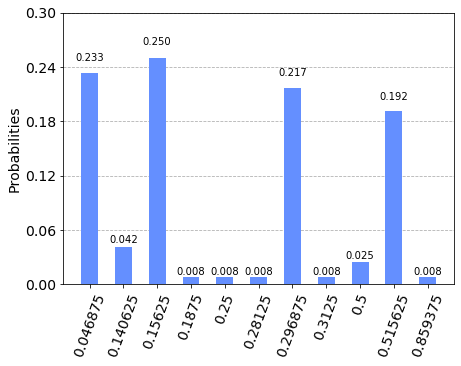

In [255]:
bits = 8
roundoff = 2
shots_per_vec1 = 10

pure_states = ortho_group.rvs(dim=N)

res = None
for i in range(N):
    initial = pure_states[i]
    if res is None:
        res = qpca(covariance_matrix,bits,initial= initial, req_shots = shots_per_vec1, nbitsroundoff = roundoff)
    else:
        res.merge(qpca(covariance_matrix,bits,initial= initial, req_shots = shots_per_vec1, nbitsroundoff = roundoff))
        
plot_histogram(res.get_eigvals(False))

We consider the $N$ most observed eigenvalues and the corresponding eigenvector estimates. This effectively gives us a rough approximation of our goal state in its eigendecomposition.\
The procedure can now be repeated for a second iteration, this time using each eigenvector estimate as pure state in a probabilistic mixture with weights given by the estimated eigenvalues. Again, this is simulated by running exactly $\lambda_k\cdot N\cdot C$ shots on each state individually, where $C$ is a constant that determines the overall number of shots as $N\cdot C$. Since now we have a better initial guess than previously, we increase this number to $1000$.

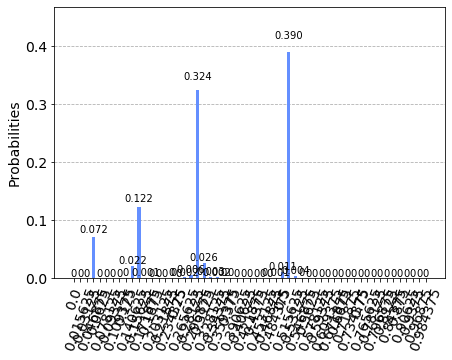

In [256]:
eigval_occurences = res.get_eigvals()
relevant_eigvals = [i[0] for i in eigval_occurences[-N:]]
eigvec_weights = [i/sum(relevant_eigvals) for i in relevant_eigvals]

shots_per_vec2 = 1000

result = None
for ev,weight in zip(relevant_eigvals,eigvec_weights):
    initial = res.eigvec_from_eigval(ev)
    if len(initial)==0:
        continue
    if result is None:
        result = qpca(covariance_matrix,bits,initial= initial, req_shots = int(shots_per_vec2*weight*N+1), nbitsroundoff = roundoff)
    else:
        result.merge(qpca(covariance_matrix,bits,initial= initial, req_shots = int(shots_per_vec2*weight*N+1), nbitsroundoff = roundoff))

plot_histogram(result.get_eigvals(False))

As we see, by measuring the output state at this second iteration we are able to efficiently extract informations on the principal components of our matrix.\
To assess the quality of our estimates, we can calculate the relative error on a low-rank reconstruction of the original matrix using this quantum eigendecomposition with respect to the one obtained using the exact eigendecomposition.\
For instance, we consider only the first $K=2$ principal components and compute the low-rank reconstruction as $V_K\Lambda_K V_K^\intercal$

In [257]:
K = 2

#RETRIEVE EIGENVALUES AND EIGVECTORS ESTIMATES
estimated_eigenvalues = sorted(result.get_eigvals()[-N:])
estimated_eigvals = [i[0] for i in estimated_eigenvalues[-K:]]

eigenvectors = [result.eigvec_from_eigval(i[0]) for i in estimated_eigenvalues]

eigval_diag = np.diag(estimated_eigvals)
estimated_eigvecs = np.array(eigenvectors[-K:]).T

#LOW RANK APPROXIMATION FROM ESTIMATED EIGENDECOMPOSITION
lowrank_covmat_est = np.matmul(np.matmul(estimated_eigvecs,eigval_diag),estimated_eigvecs.T)

#LOW RANK APPROXIMATION FROM CLASSICALLY COMPUTED EIGENDECOMPOSITION
lowrank_covmat = np.matmul(np.matmul(eigvec[:,-K:],np.diag(eigval[-K:])),eigvec[:,-K:].T)

diff = lowrank_covmat_est - lowrank_covmat
print("reconstruction relative error (l2 norm): ", np.linalg.norm(diff)/np.linalg.norm(lowrank_covmat))

reconstruction relative error (l2 norm):  0.02408373022969595


Note that this error accounts for the inaccuracy of both the eigenstates tomography and eigenvalues estimation, which can be improved respectively by increasing the number of measurements and using larger quantum registers (for holding the eigenvalues).